In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
s1_s2_genes = pd.read_csv('./gene_targets/s1_s2_genes.csv')
s2_s3_genes = pd.read_csv('./gene_targets/s2_s3_genes.csv')
s3_s4_genes = pd.read_csv('./gene_targets/s3_s4_genes.csv')

In [30]:
s1_s2_genes.columns

Index(['Gene Symbol', 'p-value', 'FDR', 'Odd ratio', 'Number of interactions',
       'microRNA 1', 'microRNA 2', 'microRNA 3', 'microRNA 4', 'microRNA 5',
       'microRNA 6'],
      dtype='object')

In [31]:
# Filter each df to only have the genes that have a p-value < 0.05
s1_s2_genes = s1_s2_genes[s1_s2_genes['p-value'] < 0.05]
s2_s3_genes = s2_s3_genes[s2_s3_genes['p-value'] < 0.05]
s3_s4_genes = s3_s4_genes[s3_s4_genes['p-value'] < 0.05]

In [32]:
# Extract the 'Gene Symbol' and miRNA columns for merging and counting
def extract_gene_mirna_columns(df):
    mirna_columns = [col for col in df.columns if col.startswith('microRNA')]
    return df[['Gene Symbol'] + mirna_columns]

s1_s2_gene_symbols = extract_gene_mirna_columns(s1_s2_genes)
s2_s3_gene_symbols = extract_gene_mirna_columns(s2_s3_genes)
s3_s4_gene_symbols = extract_gene_mirna_columns(s3_s4_genes)

In [33]:
# Concatenate the dataframes
merged_genes = pd.concat([s1_s2_gene_symbols, s2_s3_gene_symbols, s3_s4_gene_symbols], axis=0)

In [34]:
# Flatten the dataframe into a single series and count the occurrences
gene_counts = merged_genes['Gene Symbol'].value_counts().sort_values(ascending=False)

# Extract and count miRNA occurrences
miRNA_columns = [col for col in merged_genes.columns if col.startswith('microRNA')]
miRNA_counts = merged_genes[miRNA_columns].stack().value_counts().sort_values(ascending=False)

In [35]:
# Print the gene counts
print("Gene Counts:")
print(gene_counts)

Gene Counts:
Gene Symbol
ADORA2B      2
DNAJB13      2
TNFAIP8L1    2
TXK          2
FLYWCH2      2
            ..
EPHA4        1
FBXO47       1
FRMD8        1
METTL2B      1
ZNF844       1
Name: count, Length: 338, dtype: int64


In [36]:
# Print the miRNA counts
print("miRNA Counts:")
print(miRNA_counts)

miRNA Counts:
hsa-miR-498          134
hsa-miR-4722-3p      119
hsa-miR-512-3p        79
hsa-miR-6829-3p       78
hsa-miR-520b          56
hsa-miR-4680-5p       31
hsa-miR-548l          30
hsa-miR-490-3p        29
hsa-miR-106a-3p       26
hsa-miR-3973          26
hsa-miR-1207-3p       25
hsa-miR-1254          22
hsa-miR-203a-3p       22
hsa-miR-1208          20
hsa-miR-1255a         19
hsa-miR-452-5p        19
hsa-miR-3124-3p       19
hsa-miR-506-3p        17
hsa-miR-491-5p        16
hsa-miR-8072          16
hsa-miR-196a-3p       16
hsa-miR-4485-5p       15
hsa-miR-548ar-3p      15
hsa-miR-27a-5p        13
hsa-miR-5583-3p       13
hsa-miR-516b-3p       12
hsa-miR-3140-5p       12
hsa-miR-2276-3p       12
hsa-miR-4483          11
hsa-miR-4802-3p       11
hsa-miR-124-5p        10
hsa-miR-199a-5p       10
hsa-miR-8073           9
hsa-miR-6805-3p        9
hsa-miR-4715-3p        9
hsa-miR-2277-3p        8
hsa-miR-4424           8
hsa-miR-3130-3p        7
hsa-miR-122-3p         6
hsa-miR-450

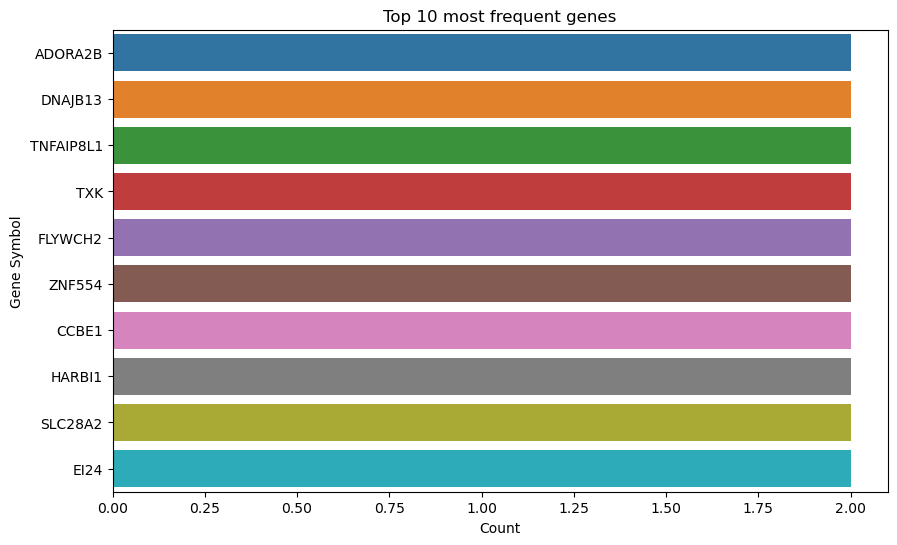

In [40]:
# Plot the top 10 most frequent genes
top_genes = gene_counts.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_genes.values, y=top_genes.index)
plt.xlabel('Count')
plt.ylabel('Gene Symbol')
plt.title('Top 10 most frequent genes')
plt.show()

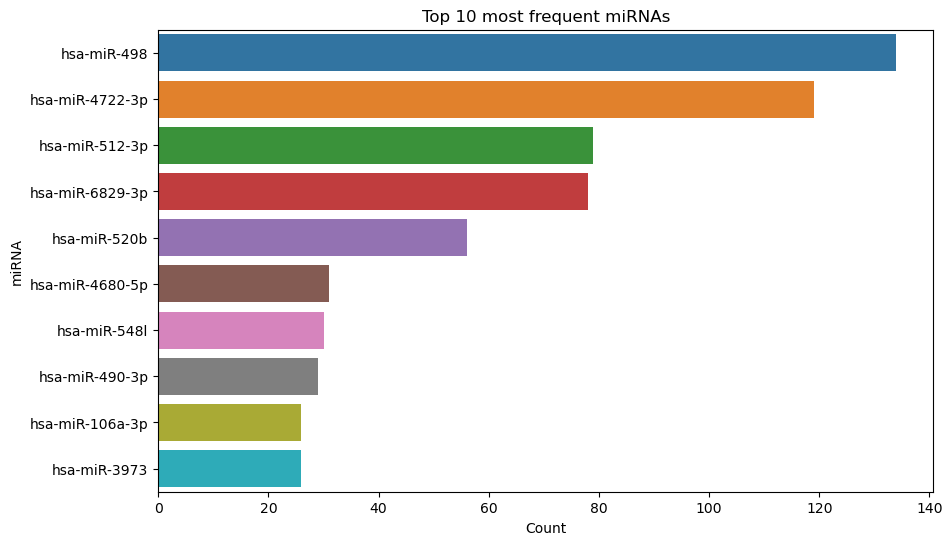

In [41]:
# Plot the top 10 most frequent miRNAs
top_miRNAs = miRNA_counts.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_miRNAs.values, y=top_miRNAs.index)
plt.xlabel('Count')
plt.ylabel('miRNA')
plt.title('Top 10 most frequent miRNAs')
plt.show()

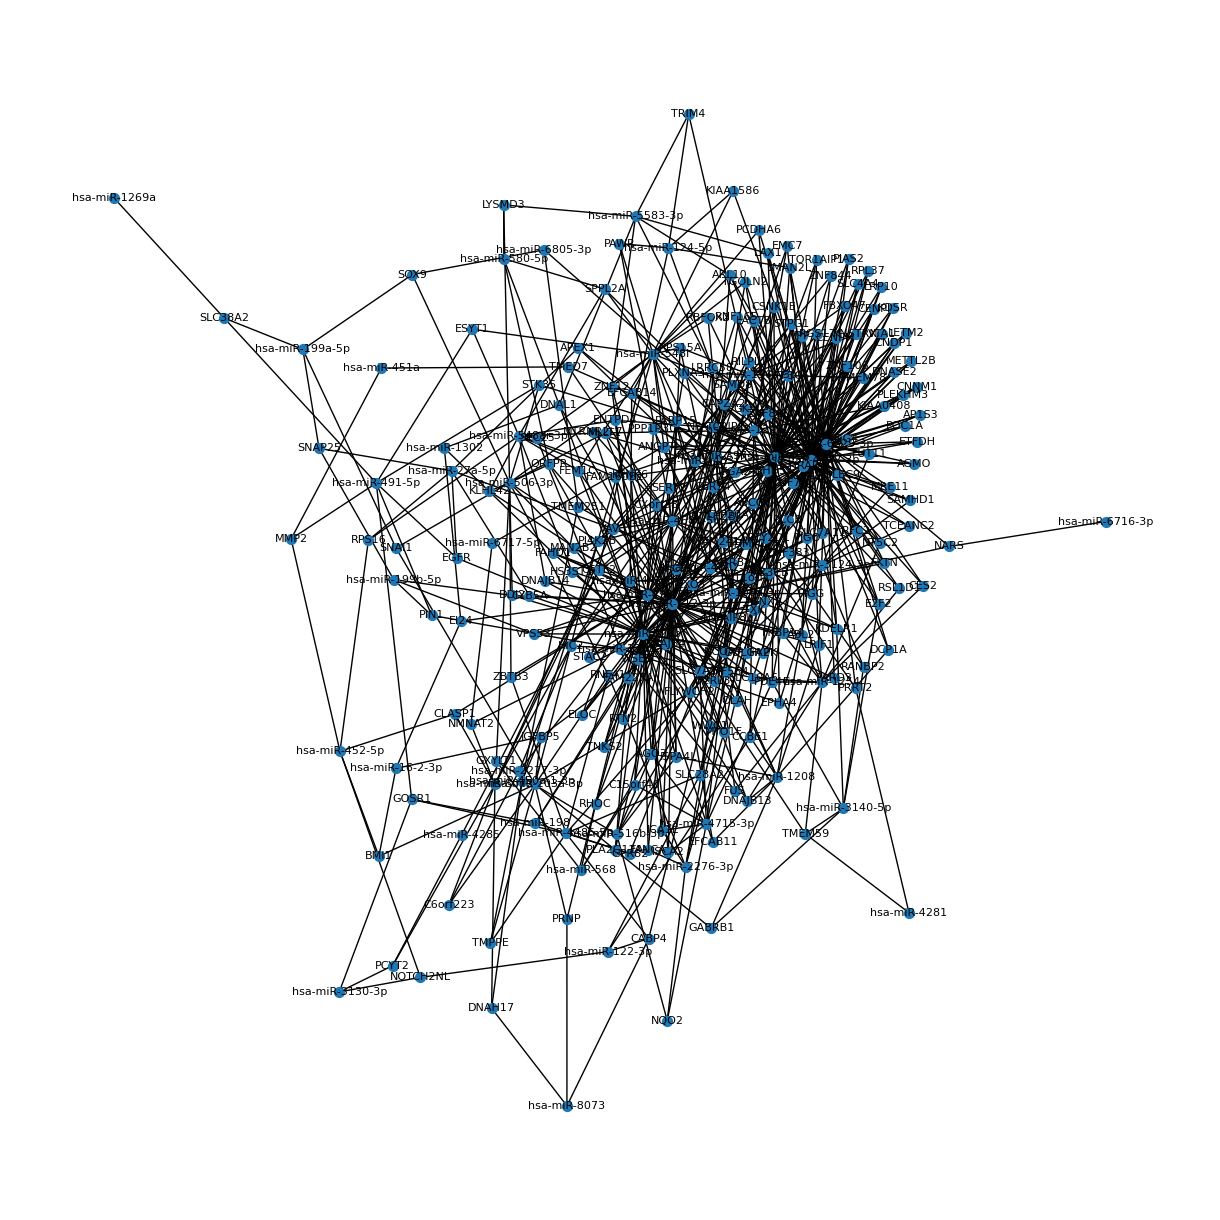

In [48]:
G = nx.Graph()

# Add nodes and edges to the network
for _, row in merged_genes.iterrows():
    gene = row['Gene Symbol']
    for miRNA in row[1:].dropna():
        G.add_node(gene, type='gene')
        G.add_node(miRNA, type='miRNA')
        G.add_edge(gene, miRNA)

# Filter genes with at least 3 miRNA connections
filtered_genes = [node for node in G.nodes if G.nodes[node]['type'] == 'gene' and len(G[node]) >= 3]

# Create a new filtered network
G_filtered = nx.Graph()

# Add filtered genes and their miRNA connections
for gene in filtered_genes:
    for miRNA in G[gene]:
        G_filtered.add_node(gene, type='gene')
        G_filtered.add_node(miRNA, type='miRNA')
        G_filtered.add_edge(gene, miRNA)

# Draw the filtered network using NetworkX (for quick visualization)
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_filtered, k=0.1)
nx.draw(G_filtered, pos, with_labels=True, node_size=50, font_size=8)
plt.show()

# Export the filtered network to GraphML format for Gephi
nx.write_graphml(G_filtered, './filtered_gene_miRNA_network_3_or_more.graphml')

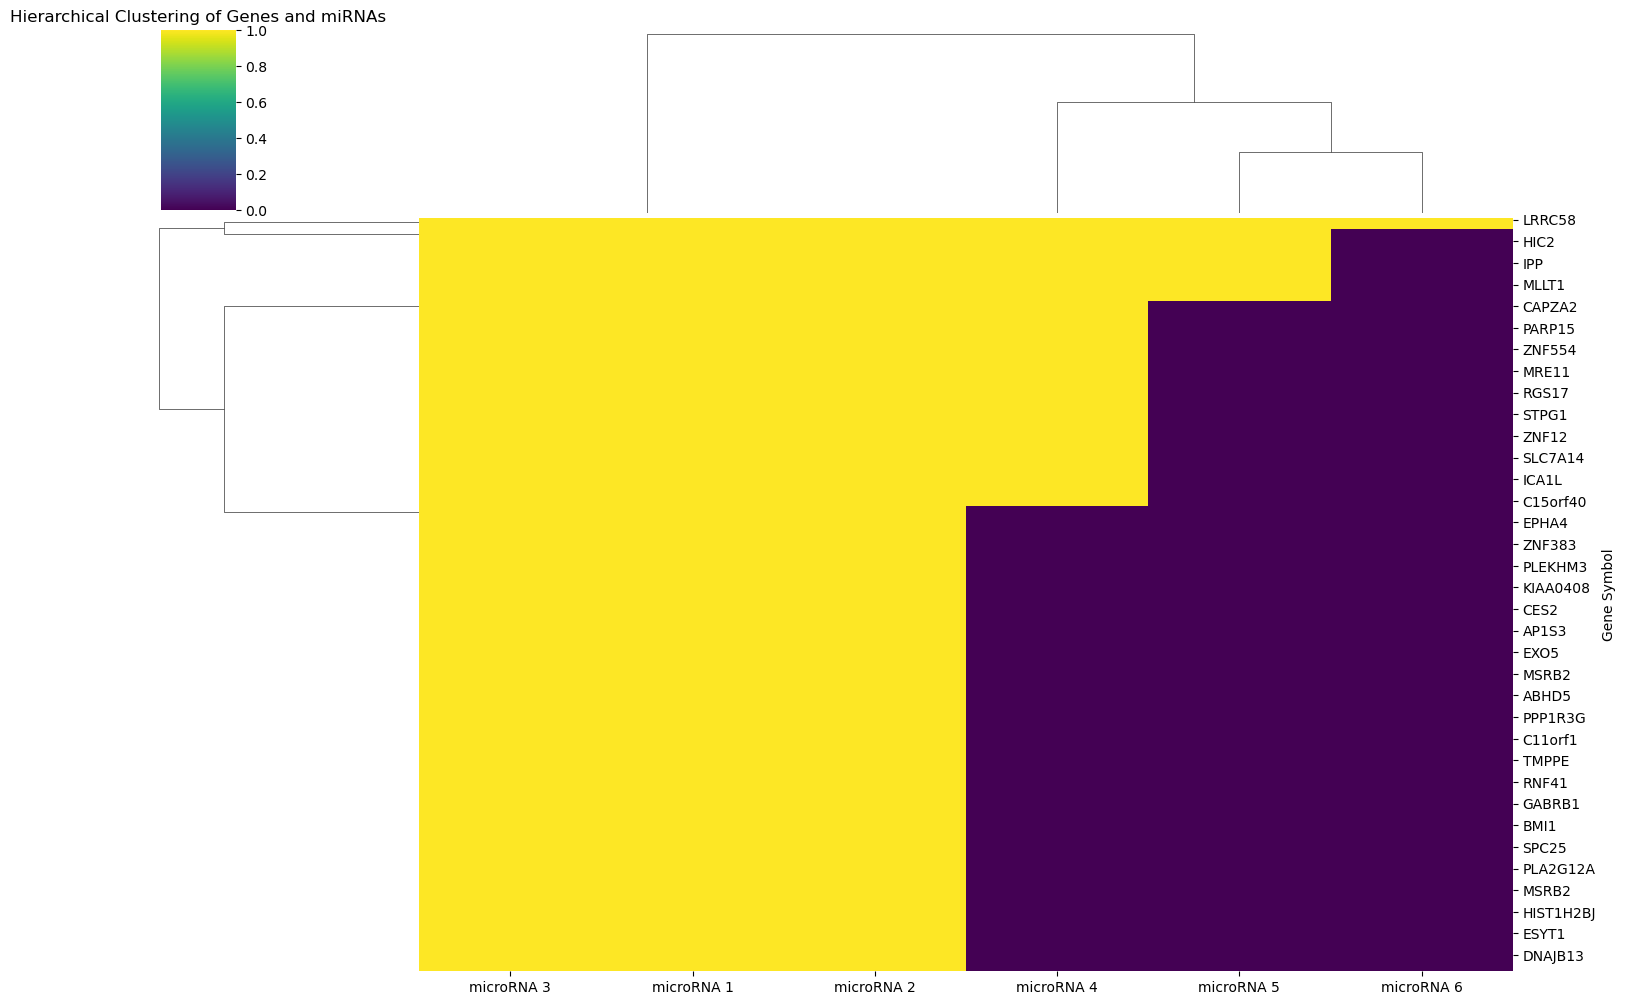

In [53]:
binary_matrix = merged_genes.set_index('Gene Symbol')[miRNA_columns].notna().astype(int)

# Filter genes with at least 3 miRNA connections
filtered_genes = binary_matrix[binary_matrix.sum(axis=1) >= 3]

# Plot the hierarchical clustering heatmap
sns.clustermap(filtered_genes, method='average', metric='euclidean', cmap='viridis', figsize=(15, 10))
plt.title('Hierarchical Clustering of Genes and miRNAs')
plt.show()

In [54]:
# Extract genes from the filtered network
filtered_genes_list = [node for node in G_filtered.nodes if G_filtered.nodes[node]['type'] == 'gene']

# Save the filtered genes to a CSV file
filtered_genes_df = pd.DataFrame(filtered_genes_list, columns=['Gene Symbol'])
filtered_genes_df.to_csv('./filtered_genes_for_enrichment_analysis.csv', index=False)

print("Filtered genes have been saved to 'filtered_genes_for_enrichment_analysis.csv'")


Filtered genes have been saved to 'filtered_genes_for_enrichment_analysis.csv'
